In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE_pendulum import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
class PendulumDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_intervals = df['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df['interval'] == batch
        theta = torch.tensor(self.df[id]['theta'].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.df[id]['t'].to_numpy(), dtype=torch.float32)  # Normalize time

        # Concatenate theta and t as input batch
        x_batch = torch.cat((theta.unsqueeze(1), t.unsqueeze(1)), axis=1)
        return x_batch # Also return omega for plotting

# Load the dataset
df_damped = pd.read_csv("../Data/damped_pendulum_data.csv")
df_damped['interval'] = df_damped['omega'].astype('category').cat.codes
df_damped['theta'] = df_damped['theta']
# df_damped = df_damped[df_damped['t'] <= 10]

dataset = PendulumDataset(df_damped)

train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 42
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)


In [3]:
df_damped.head()

theta        t  omega  interval
0 -0.154574  0.00000    0.8         0
1 -0.173020  0.10101    0.8         0
2 -0.191944  0.20202    0.8         0
3 -0.325472  0.30303    0.8         0
4 -0.163832  0.40404    0.8         0

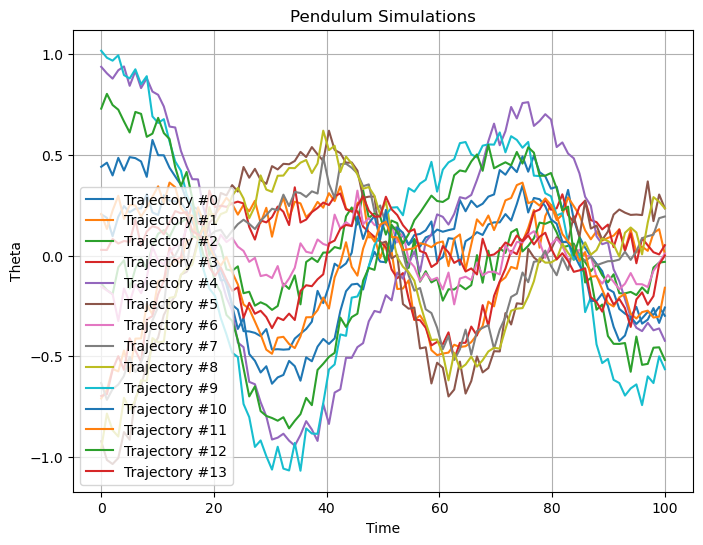

In [4]:
plt.figure(figsize=(8, 6))

for i, x_batch in enumerate(train_loader):
    # x_batch has shape (1, N, 2) if batch_size=1
    x_batch = x_batch.squeeze(0)  # Now shape is (N, 2)

    # Extract theta and time
    theta_values = x_batch[:, 0].numpy()
    time_values = x_batch[:, 1].numpy() * 10  # Reverse normalization

    plt.plot(time_values, theta_values, label=f'Trajectory #{i}')

plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Pendulum Simulations")
plt.legend()
plt.grid()
plt.show()


In [5]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
torch.manual_seed(42)
model = GPVAE(GP_inf = GP_inference(kernel), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10]
              )

In [6]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [7]:
for i, x_batch in enumerate(train_loader):  
    x_batch = x_batch.squeeze(0)  

    t_i = x_batch[:, 1].numpy()  
    t_uni = torch.tensor(t_i)  

    print(f"Iteration {i}: t_uni shape = {t_uni.shape}")  

    if i == 0:
        break 


Iteration 0: t_uni shape = torch.Size([100])


Training Progress:   0%|          | 0/400 [00:00<?, ?it/s]

Training Progress:   5%|▍         | 19/400 [00:01<00:30, 12.64it/s]

Epoch 20:
  Training - Loss = 0.0375, KL = 0.2963, MSE = 0.0405, CE = 0.5419
  Validation - Loss = 0.0310, KL = 0.3006, MSE = 0.0340, CE = 0.5437
  Mean q_mu = -0.0164, Mean q_var = 0.1353


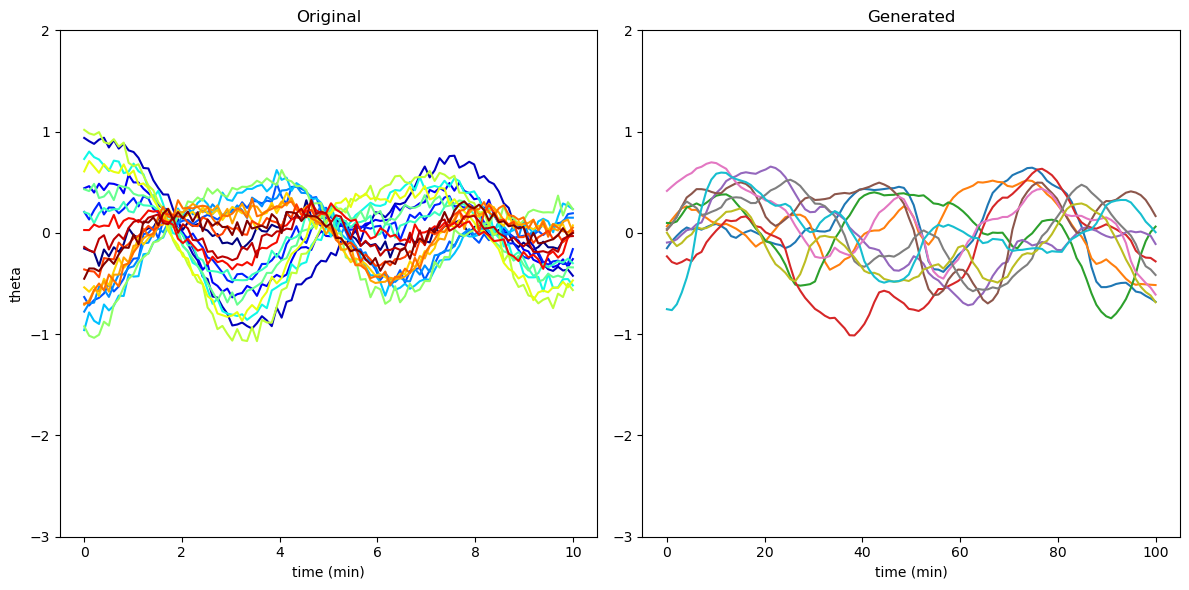

Training Progress:  10%|▉         | 39/400 [00:03<00:30, 11.79it/s]

Epoch 40:
  Training - Loss = 0.0145, KL = 0.2393, MSE = 0.0169, CE = 0.5872
  Validation - Loss = 0.0133, KL = 0.2547, MSE = 0.0159, CE = 0.5898
  Mean q_mu = 0.1380, Mean q_var = 0.1353


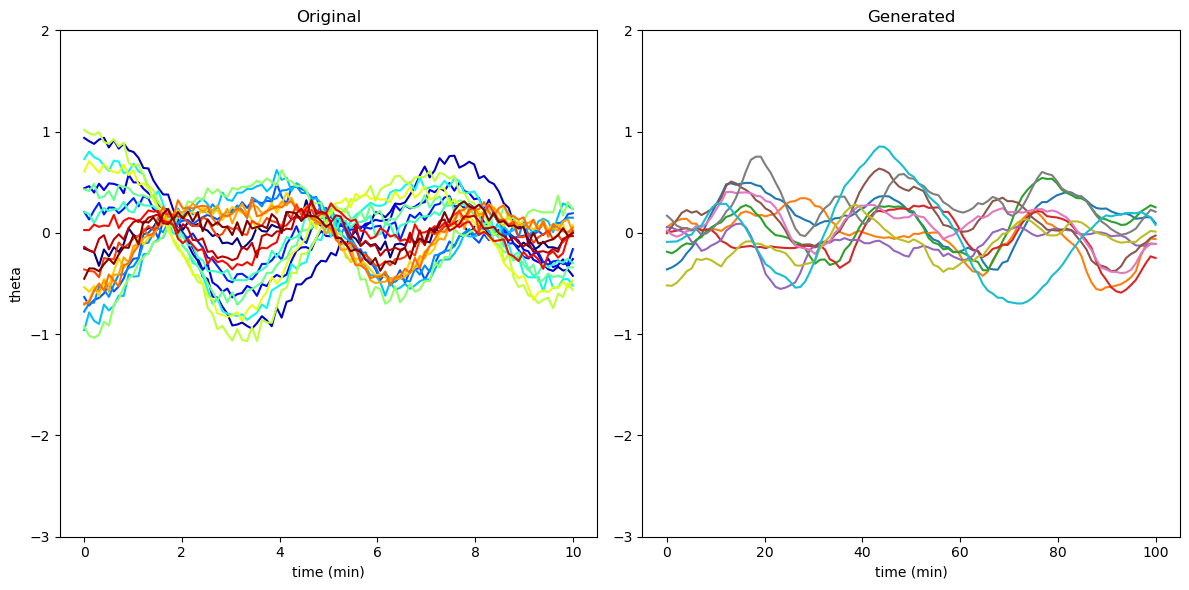

Training Progress:  15%|█▍        | 59/400 [00:05<00:27, 12.50it/s]

Epoch 60:
  Training - Loss = 0.0105, KL = 0.1859, MSE = 0.0123, CE = 0.6309
  Validation - Loss = 0.0088, KL = 0.2104, MSE = 0.0109, CE = 0.6346
  Mean q_mu = 0.1984, Mean q_var = 0.1353


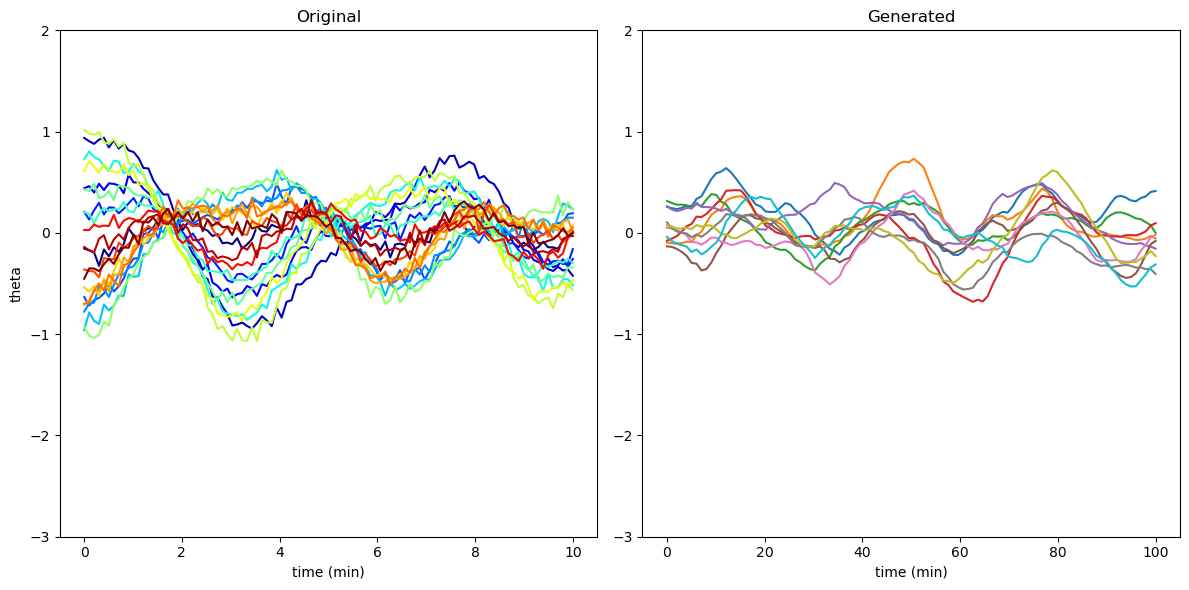

Training Progress:  20%|█▉        | 79/400 [00:06<00:25, 12.65it/s]

Epoch 80:
  Training - Loss = 0.0085, KL = 0.1385, MSE = 0.0099, CE = 0.6722
  Validation - Loss = 0.0074, KL = 0.1707, MSE = 0.0091, CE = 0.6775
  Mean q_mu = 0.1946, Mean q_var = 0.1353


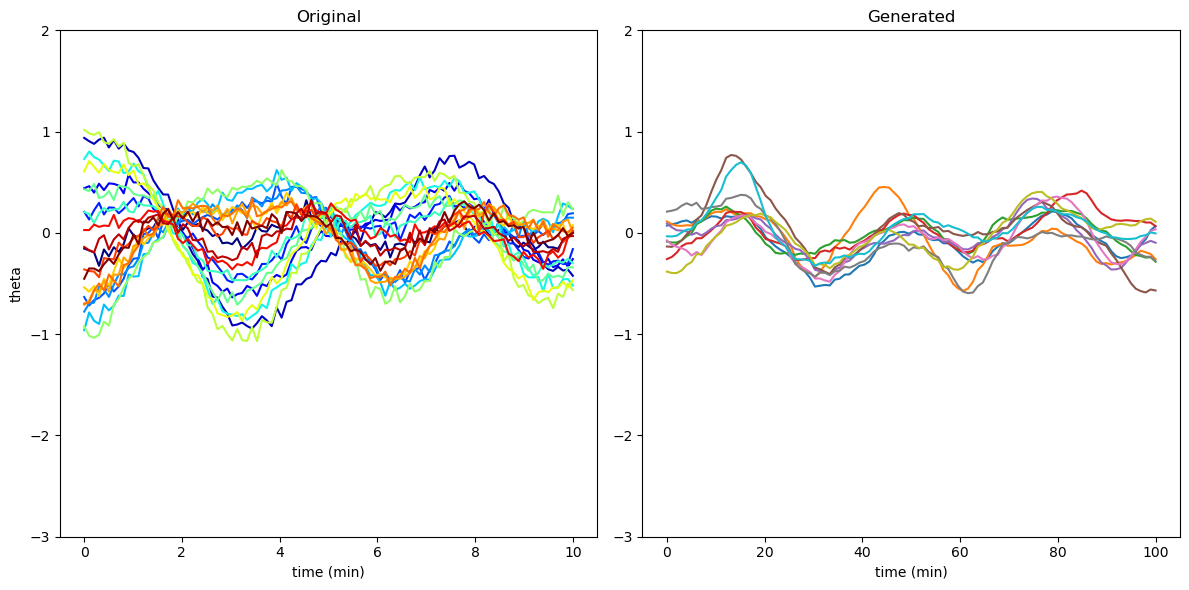

Training Progress:  25%|██▍       | 99/400 [00:08<00:23, 12.57it/s]

Epoch 100:
  Training - Loss = 0.0074, KL = 0.0995, MSE = 0.0084, CE = 0.7082
  Validation - Loss = 0.0066, KL = 0.1380, MSE = 0.0080, CE = 0.7146
  Mean q_mu = 0.1816, Mean q_var = 0.1353


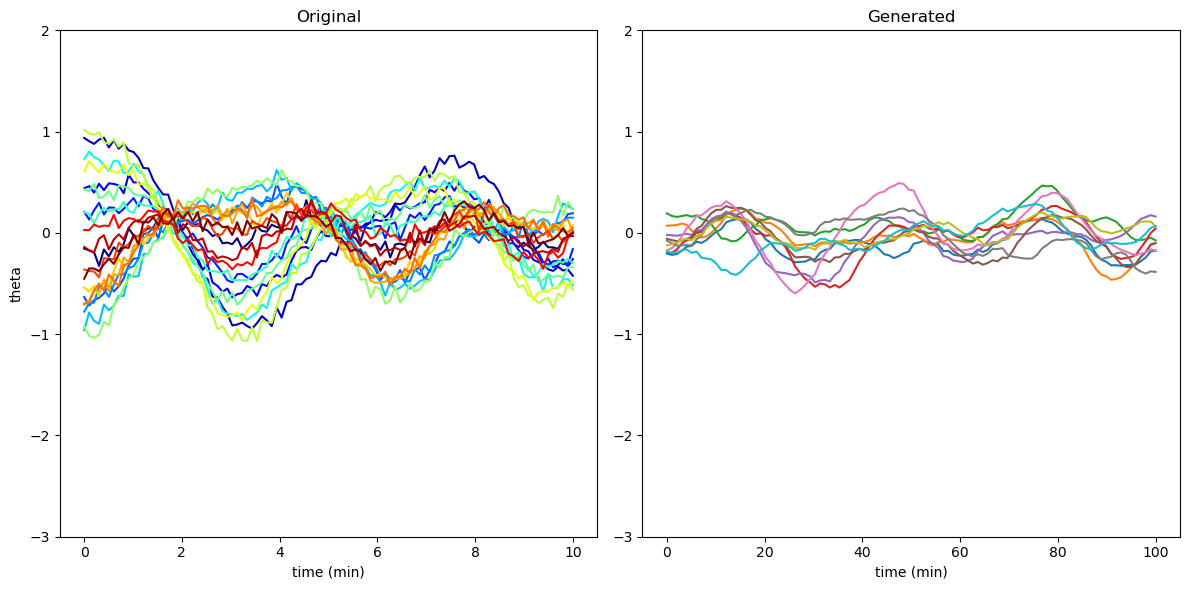

Training Progress:  30%|██▉       | 119/400 [00:10<00:23, 12.09it/s]

Epoch 120:
  Training - Loss = 0.0072, KL = 0.0675, MSE = 0.0079, CE = 0.7396
  Validation - Loss = 0.0058, KL = 0.1109, MSE = 0.0069, CE = 0.7470
  Mean q_mu = 0.1655, Mean q_var = 0.1353


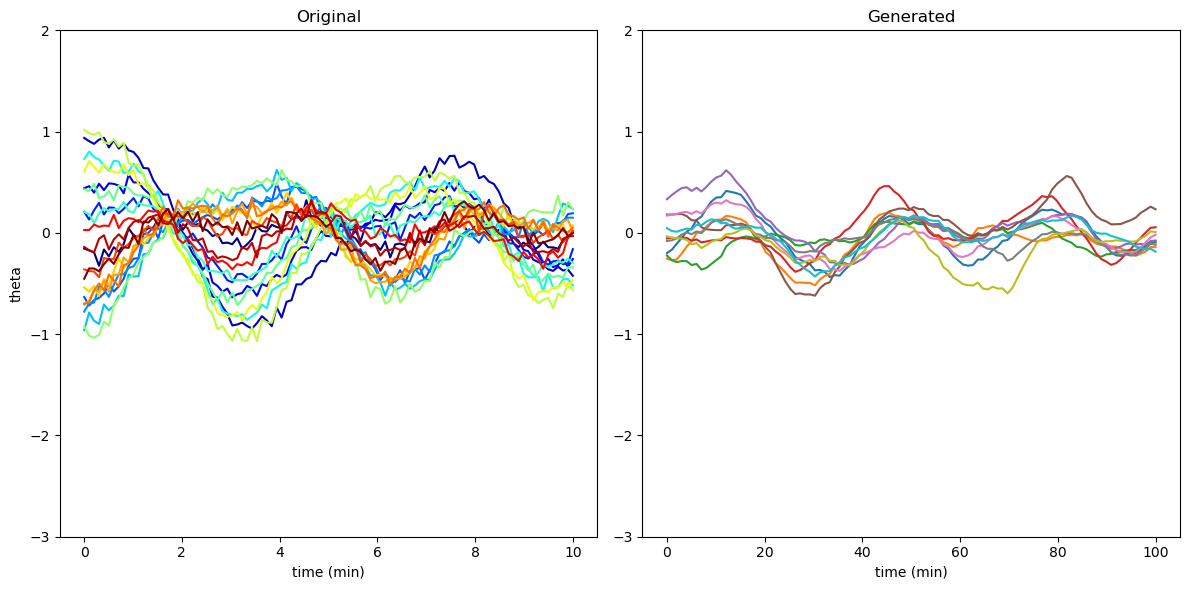

Training Progress:  35%|███▍      | 139/400 [00:12<00:21, 12.31it/s]

Epoch 140:
  Training - Loss = 0.0062, KL = 0.0444, MSE = 0.0066, CE = 0.7640
  Validation - Loss = 0.0057, KL = 0.0918, MSE = 0.0067, CE = 0.7720
  Mean q_mu = 0.1529, Mean q_var = 0.1353


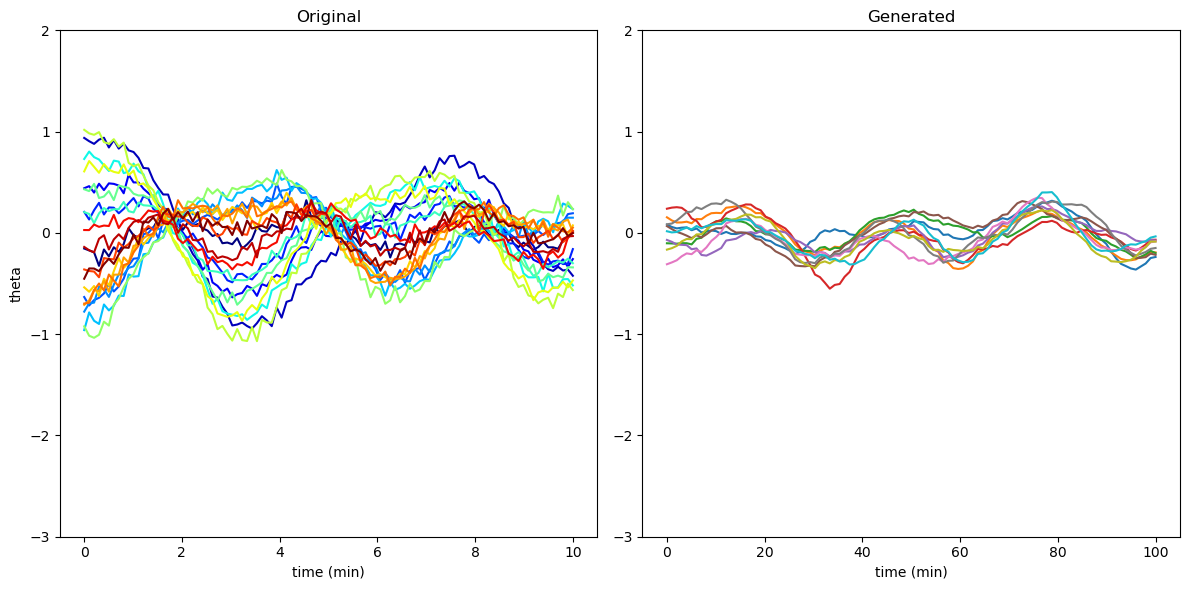

Training Progress:  40%|███▉      | 159/400 [00:14<00:21, 11.04it/s]

Epoch 160:
  Training - Loss = 0.0059, KL = 0.0263, MSE = 0.0061, CE = 0.7847
  Validation - Loss = 0.0054, KL = 0.0766, MSE = 0.0061, CE = 0.7933
  Mean q_mu = 0.1298, Mean q_var = 0.1353


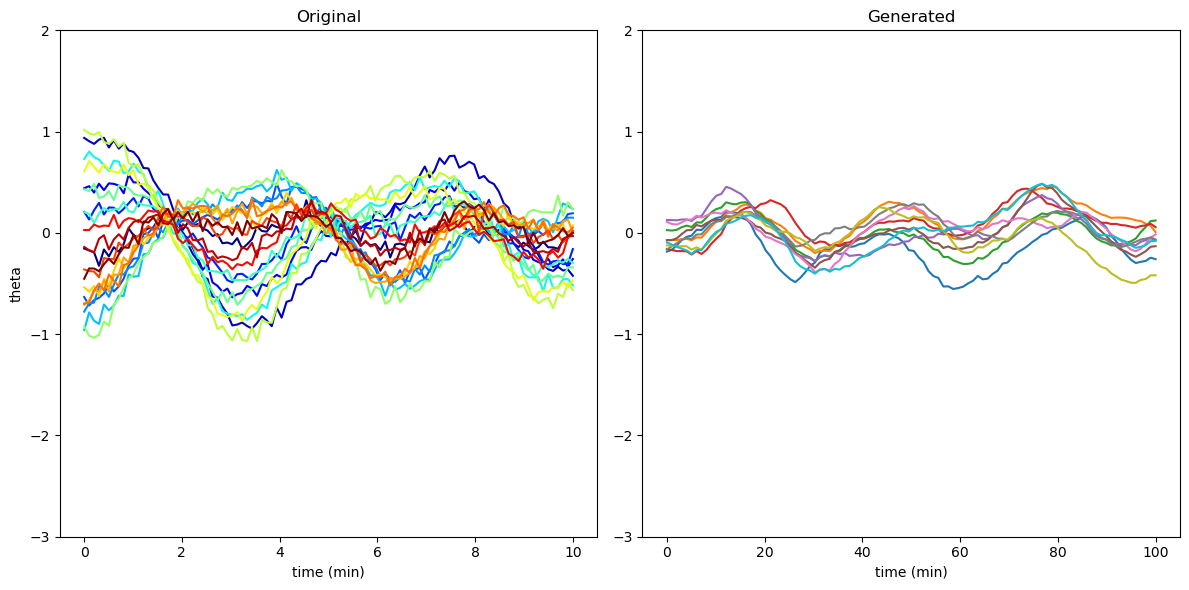

Training Progress:  44%|████▍     | 178/400 [00:15<00:18, 12.05it/s]

Epoch 180:
  Training - Loss = 0.0064, KL = 0.0157, MSE = 0.0066, CE = 0.7985
  Validation - Loss = 0.0052, KL = 0.0674, MSE = 0.0059, CE = 0.8083
  Mean q_mu = 0.1223, Mean q_var = 0.1353


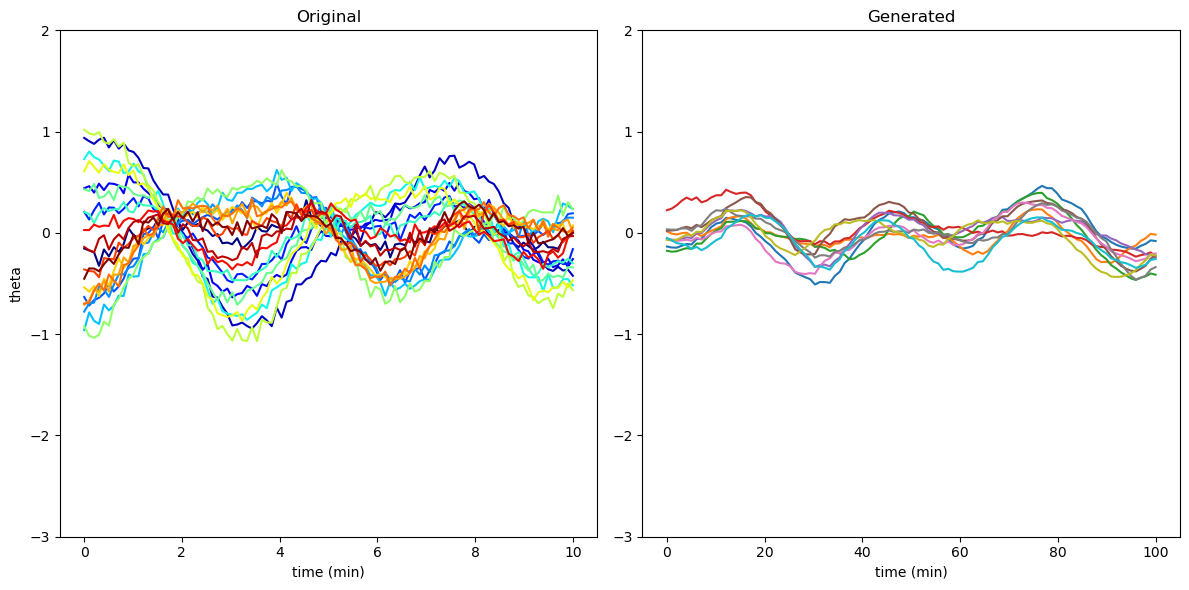

Training Progress:  50%|████▉     | 198/400 [00:17<00:16, 12.34it/s]

Epoch 200:
  Training - Loss = 0.0062, KL = 0.0071, MSE = 0.0063, CE = 0.8110
  Validation - Loss = 0.0048, KL = 0.0605, MSE = 0.0054, CE = 0.8205
  Mean q_mu = 0.1055, Mean q_var = 0.1353


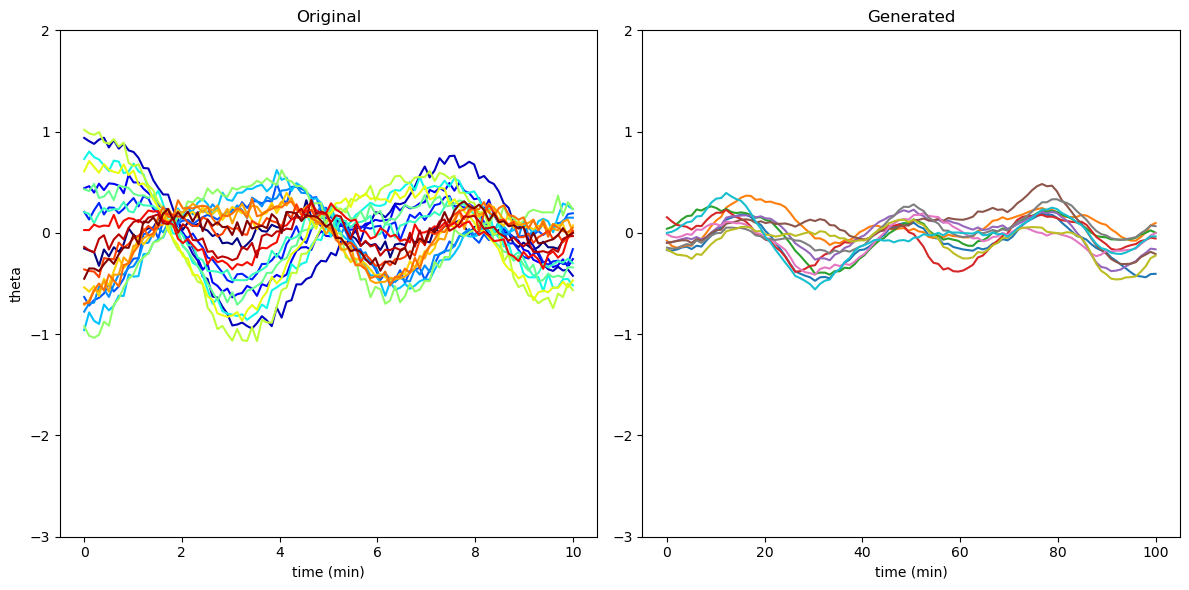

Training Progress:  55%|█████▍    | 218/400 [00:19<00:15, 11.93it/s]

Epoch 220:
  Training - Loss = 0.0059, KL = 0.0048, MSE = 0.0060, CE = 0.8170
  Validation - Loss = 0.0052, KL = 0.0595, MSE = 0.0058, CE = 0.8260
  Mean q_mu = 0.1029, Mean q_var = 0.1353


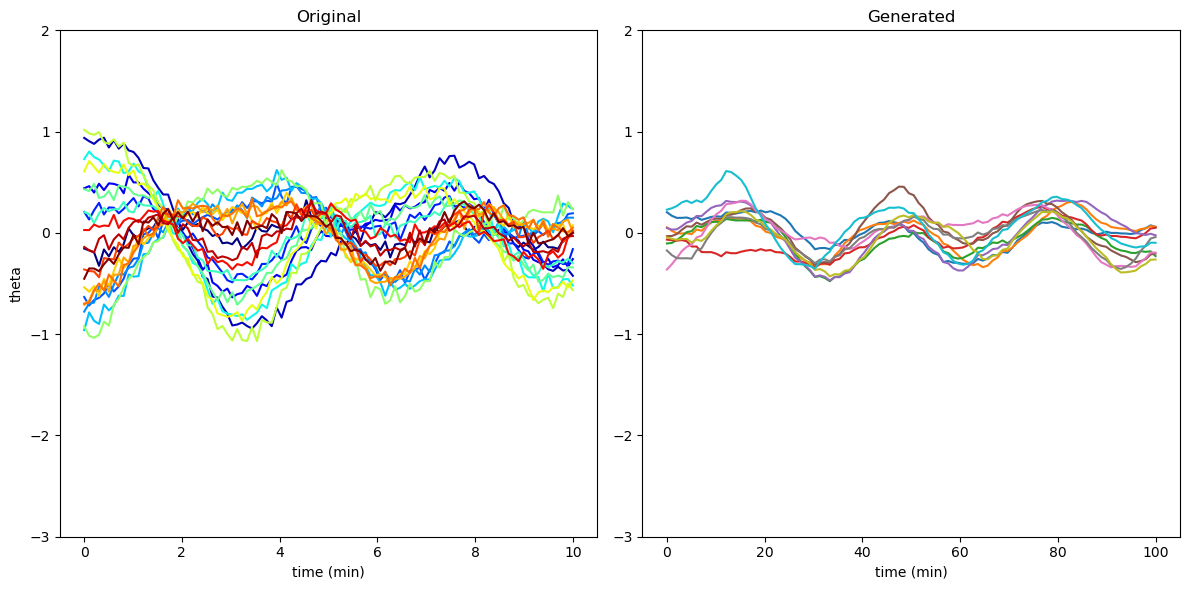

Training Progress:  60%|█████▉    | 238/400 [00:20<00:13, 12.33it/s]

Epoch 240:
  Training - Loss = 0.0062, KL = 0.0008, MSE = 0.0062, CE = 0.8249
  Validation - Loss = 0.0055, KL = 0.0562, MSE = 0.0061, CE = 0.8342
  Mean q_mu = 0.0938, Mean q_var = 0.1353


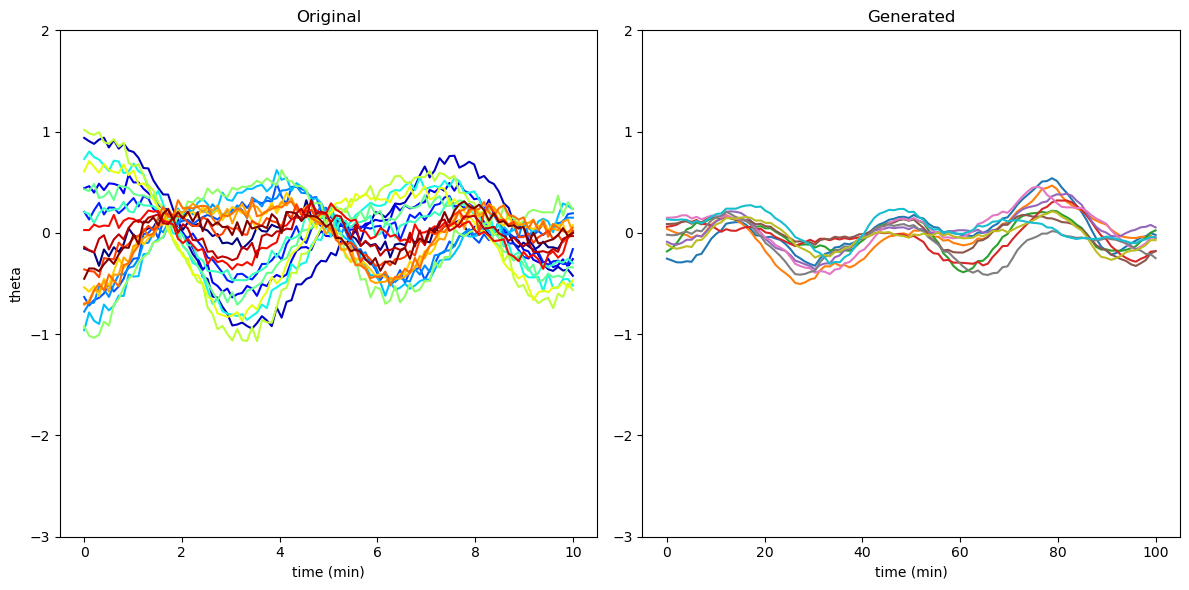

Training Progress:  64%|██████▍   | 258/400 [00:22<00:11, 12.32it/s]

Epoch 260:
  Training - Loss = 0.0060, KL = -0.0000, MSE = 0.0060, CE = 0.8299
  Validation - Loss = 0.0047, KL = 0.0563, MSE = 0.0053, CE = 0.8384
  Mean q_mu = 0.0669, Mean q_var = 0.1353


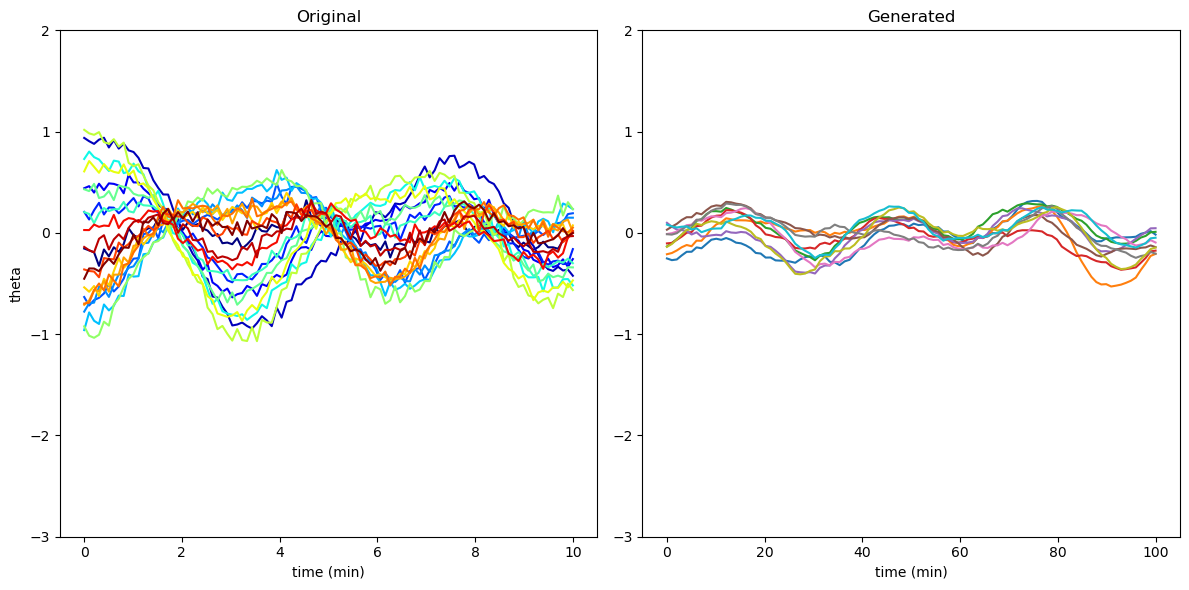

Training Progress:  70%|██████▉   | 278/400 [00:24<00:10, 12.07it/s]

Epoch 280:
  Training - Loss = 0.0059, KL = 0.0020, MSE = 0.0059, CE = 0.8315
  Validation - Loss = 0.0048, KL = 0.0584, MSE = 0.0054, CE = 0.8396
  Mean q_mu = 0.0755, Mean q_var = 0.1353


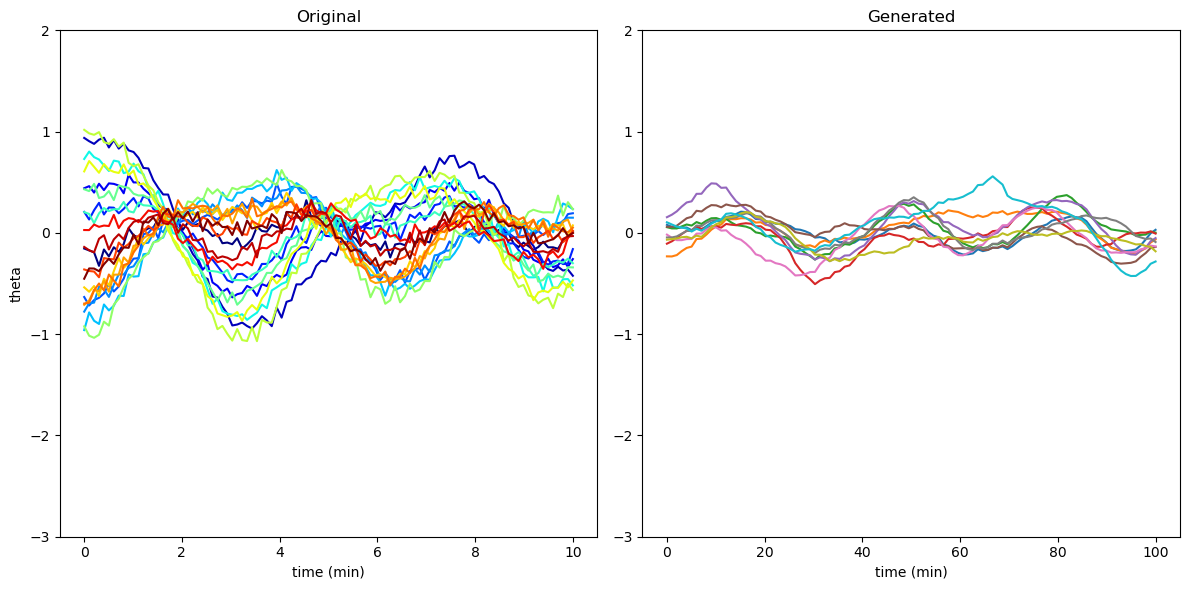

Training Progress:  74%|███████▍  | 298/400 [00:26<00:08, 12.31it/s]

Epoch 300:
  Training - Loss = 0.0059, KL = 0.0028, MSE = 0.0059, CE = 0.8342
  Validation - Loss = 0.0049, KL = 0.0588, MSE = 0.0055, CE = 0.8428
  Mean q_mu = 0.0757, Mean q_var = 0.1353


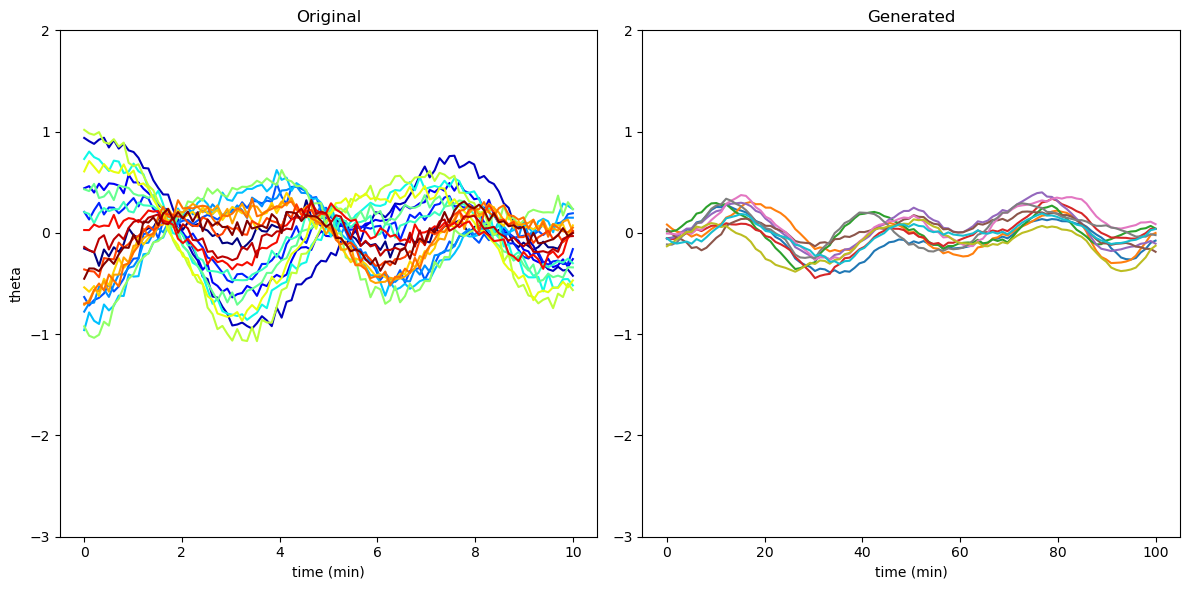

Training Progress:  80%|███████▉  | 318/400 [00:27<00:06, 12.27it/s]

Epoch 320:
  Training - Loss = 0.0058, KL = 0.0054, MSE = 0.0058, CE = 0.8352
  Validation - Loss = 0.0047, KL = 0.0612, MSE = 0.0053, CE = 0.8435
  Mean q_mu = 0.0697, Mean q_var = 0.1353


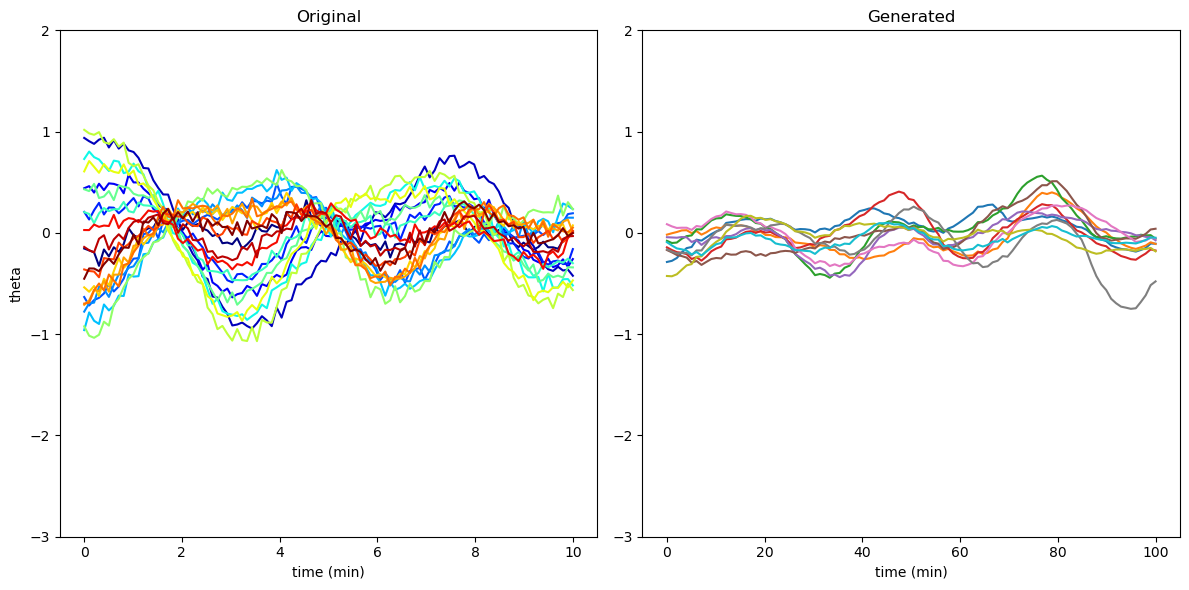

Training Progress:  84%|████████▍ | 338/400 [00:29<00:05, 11.98it/s]

Epoch 340:
  Training - Loss = 0.0056, KL = 0.0086, MSE = 0.0057, CE = 0.8354
  Validation - Loss = 0.0049, KL = 0.0639, MSE = 0.0055, CE = 0.8437
  Mean q_mu = 0.0534, Mean q_var = 0.1353


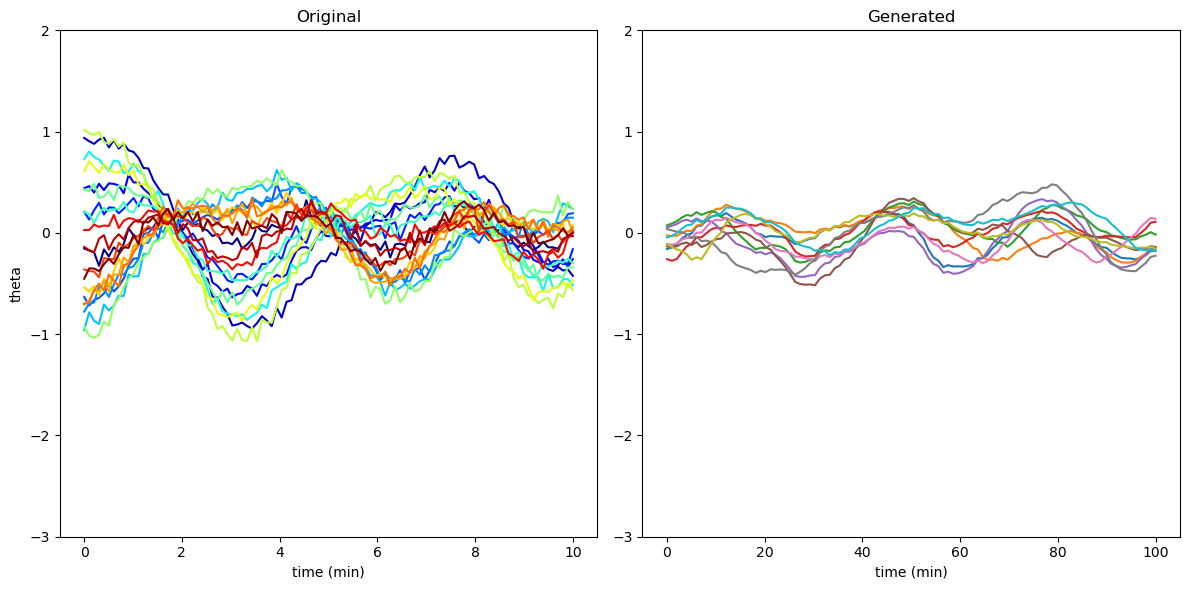

Training Progress:  90%|████████▉ | 358/400 [00:31<00:03, 11.97it/s]

Epoch 360:
  Training - Loss = 0.0057, KL = 0.0094, MSE = 0.0058, CE = 0.8380
  Validation - Loss = 0.0051, KL = 0.0658, MSE = 0.0057, CE = 0.8446
  Mean q_mu = 0.0592, Mean q_var = 0.1353


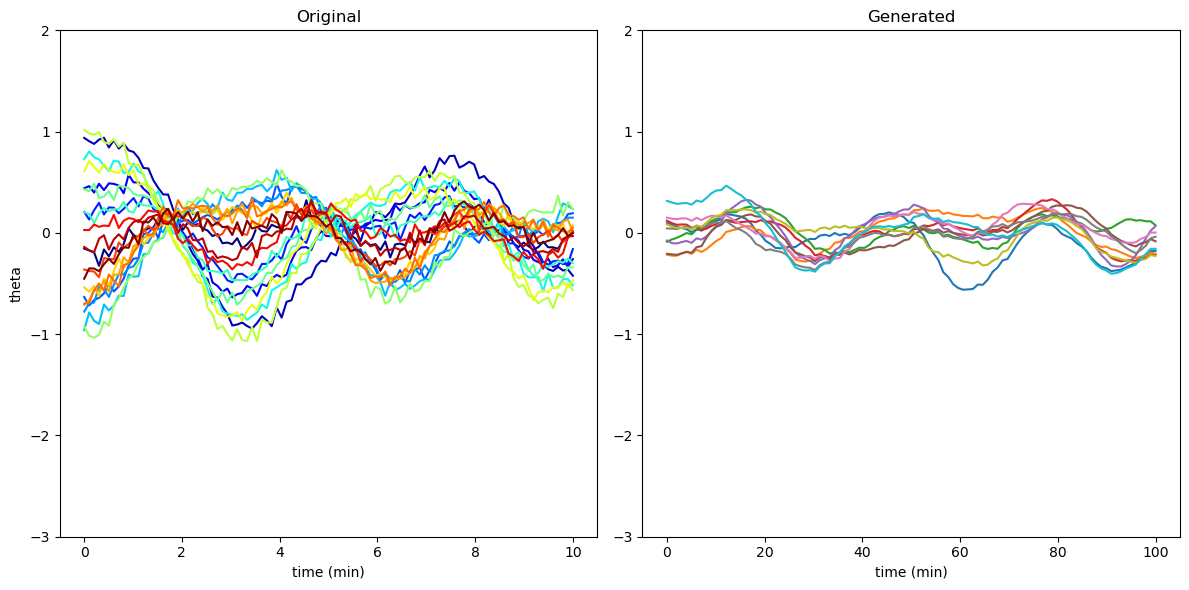

Training Progress:  94%|█████████▍| 378/400 [00:33<00:01, 12.03it/s]

Epoch 380:
  Training - Loss = 0.0058, KL = 0.0107, MSE = 0.0059, CE = 0.8399
  Validation - Loss = 0.0049, KL = 0.0659, MSE = 0.0055, CE = 0.8479
  Mean q_mu = 0.0513, Mean q_var = 0.1353


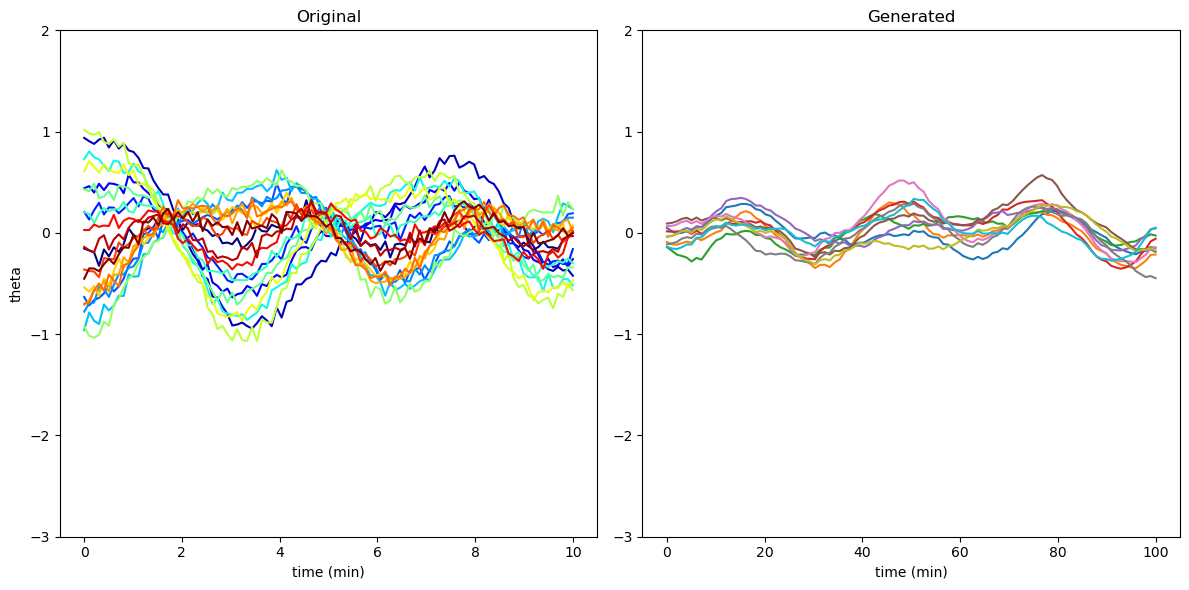

Training Progress: 100%|█████████▉| 398/400 [00:35<00:00, 12.04it/s]

Epoch 400:
  Training - Loss = 0.0057, KL = 0.0091, MSE = 0.0057, CE = 0.8451
  Validation - Loss = 0.0048, KL = 0.0659, MSE = 0.0055, CE = 0.8515
  Mean q_mu = 0.0416, Mean q_var = 0.1353


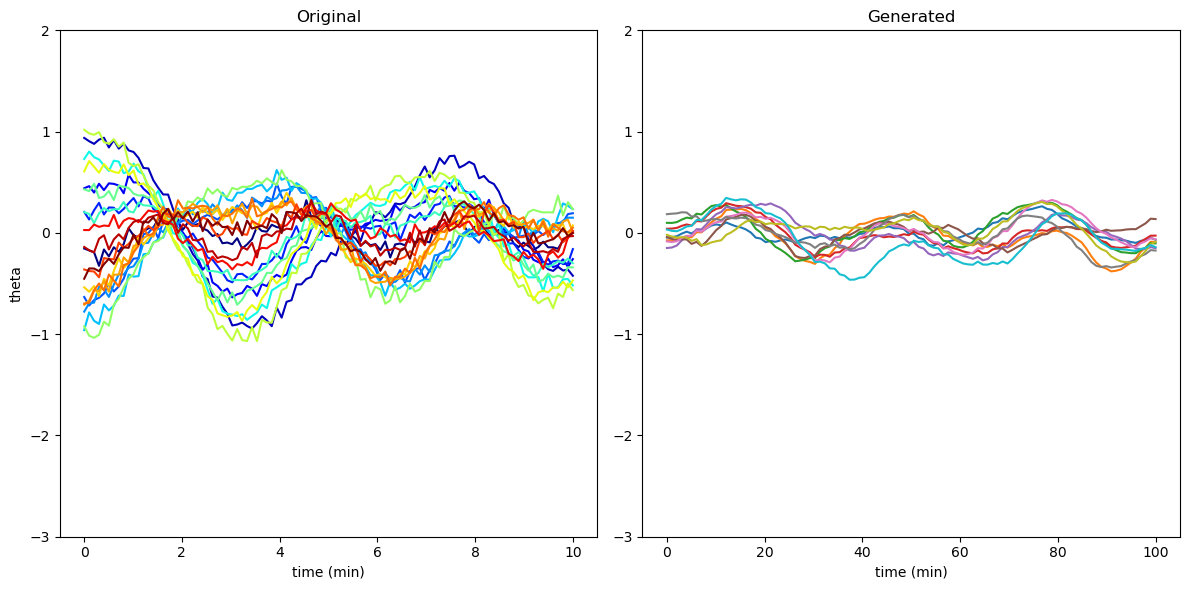

Training Progress: 100%|██████████| 400/400 [00:35<00:00, 11.30it/s]


In [8]:
beta = 0.01
num_epochs = 400
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni, 
                    num_samples=10, 
                    ylim=(-3,2), 
                    df=df_damped, 
                    plot=True)

In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/GPVAE_pendulum.pth')